In [1]:
import utils as ui
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
import pandas as pd
import numpy as np
from keras.layers import Bidirectional,Dropout,LSTM,Dense,LeakyReLU
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from keras.models import Model,Sequential
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df_PPCA= ui.load_csv('Datasets\With Imputation\PPCA Imputation\Ghaziabad_PPCA.csv')

In [3]:
features_to_select = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'Ozone', 'Temp', 'RH','WS','WD']
df_PPCA=df_PPCA[features_to_select]

In [4]:
df_train,df_test=ui.train_test_split(df_PPCA)

In [5]:
df_train[features_to_select],scaler=ui.scaling(df_PPCA,features_to_scale=features_to_select,scaler=RobustScaler(),s=True,r=True)
df_test[features_to_select]=ui.scaling(df_PPCA,features_to_scale=features_to_select,scaler=RobustScaler())

Max value of scaled 'PM2.5': 7.7124735729386895
Min value of scaled 'PM2.5': -0.6997885835095138
count    33217.000000
mean         0.352045
std          1.044263
min         -0.699789
25%         -0.334038
50%          0.000000
75%          0.665962
max          7.712474
Name: PM2.5, dtype: float64


In [6]:
X,Y=ui.data_formating(df_train)

X shape == (28694, 48, 14).
Y shape == (28694, 1).


In [7]:
def LSTM_Model(X,Y):

    model = Sequential()
    model.add(Bidirectional(LSTM(64, input_shape=(X.shape[1],X.shape[2]), return_sequences=  False)))
    model.add(LeakyReLU(0.69))
    model.add(Dropout(0.2))
    model.add(Dense(Y.shape[1],activation='linear'))
    model.compile(optimizer='adam', loss='mse')

    cp=ModelCheckpoint('models/model_epoch_{epoch:02d}.h5',save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # fit the model
    history = model.fit(X,Y, epochs=15, batch_size=24, validation_split=0.2, verbose=1,callbacks=[cp,early_stopping])

    model.summary()

    # Print final training and validation loss
    print("Final training loss:", history.history['loss'][-1])
    print("Final validation loss:", history.history['val_loss'][-1])

    ui.plot_loss(history)

    ask = input("Do You Want To Continue? (Yes/No) ").strip().lower()
    i=0
    while ask=='yes':

        cp=ModelCheckpoint('models/model_epoch_'+ str(i) +'_{epoch:02d}.h5',save_best_only=True)

        # Continue training
        history = model.fit(X, Y, epochs=5, batch_size=24, validation_split=0.2, verbose=1, callbacks=[cp, early_stopping])
        
        # Print final training and validation loss
        print("Final training loss:", history.history['loss'][-1])
        print("Final validation loss:", history.history['val_loss'][-1])

        ui.plot_loss(history)
        
        # Ask again
        ask = input("Do You Want To Continue? (Yes/No) ").strip().lower()
        i=i+1

    return model

In [8]:
def XGB_Model(X,Y):

    X = X.reshape(X.shape[0], -1)

    model = XGBRegressor()

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate MSE
    mse = mean_squared_error(y_test, predictions, squared=False)
    print("Mean Squared Error:", mse)

    # Calculating the RMSE
    rmse = sqrt(mse)
    print("Root Mean Squared Error:", rmse)

    return model


In [22]:
model=LSTM_Model(X,Y)

Epoch 1/15
957/957 [==============================] - 20s 18ms/step - loss: 0.2897 - val_loss: 0.1424
Epoch 2/15
957/957 [==============================] - 15s 16ms/step - loss: 0.1865 - val_loss: 0.1211
Epoch 3/15
957/957 [==============================] - 15s 16ms/step - loss: 0.1741 - val_loss: 0.1312
Epoch 4/15
957/957 [==============================] - 14s 15ms/step - loss: 0.1682 - val_loss: 0.1225
Epoch 5/15
957/957 [==============================] - 15s 16ms/step - loss: 0.1631 - val_loss: 0.1172
Epoch 6/15
957/957 [==============================] - 14s 15ms/step - loss: 0.1577 - val_loss: 0.1248
Epoch 7/15
957/957 [==============================] - 15s 16ms/step - loss: 0.1574 - val_loss: 0.1161
Epoch 8/15
957/957 [==============================] - 16s 17ms/step - loss: 0.1549 - val_loss: 0.1166
Epoch 9/15
957/957 [==============================] - 16s 17ms/step - loss: 0.1513 - val_loss: 0.1175
Epoch 10/15
957/957 [==============================] - 16s 16ms/step - loss: 0.146

In [9]:
model.save('./Best_Model/model.h5')
model=load_model('./Best_Model/model.h5')

X shape == (5147, 48, 14).
Y shape == (5147, 1).
161/161 [==============================] - 2s 7ms/step
Mean Squared Error (MSE) of Scaled Values: 0.0528202989565
Root Mean Squared Error (RMSE) of Scaled Values: 0.22982667155162823
Mean Squared Error (MSE) of Unscaled Values: 738.5895333000385
Root Mean Squared Error (RMSE) of Unscaled Values: 27.177003758693463


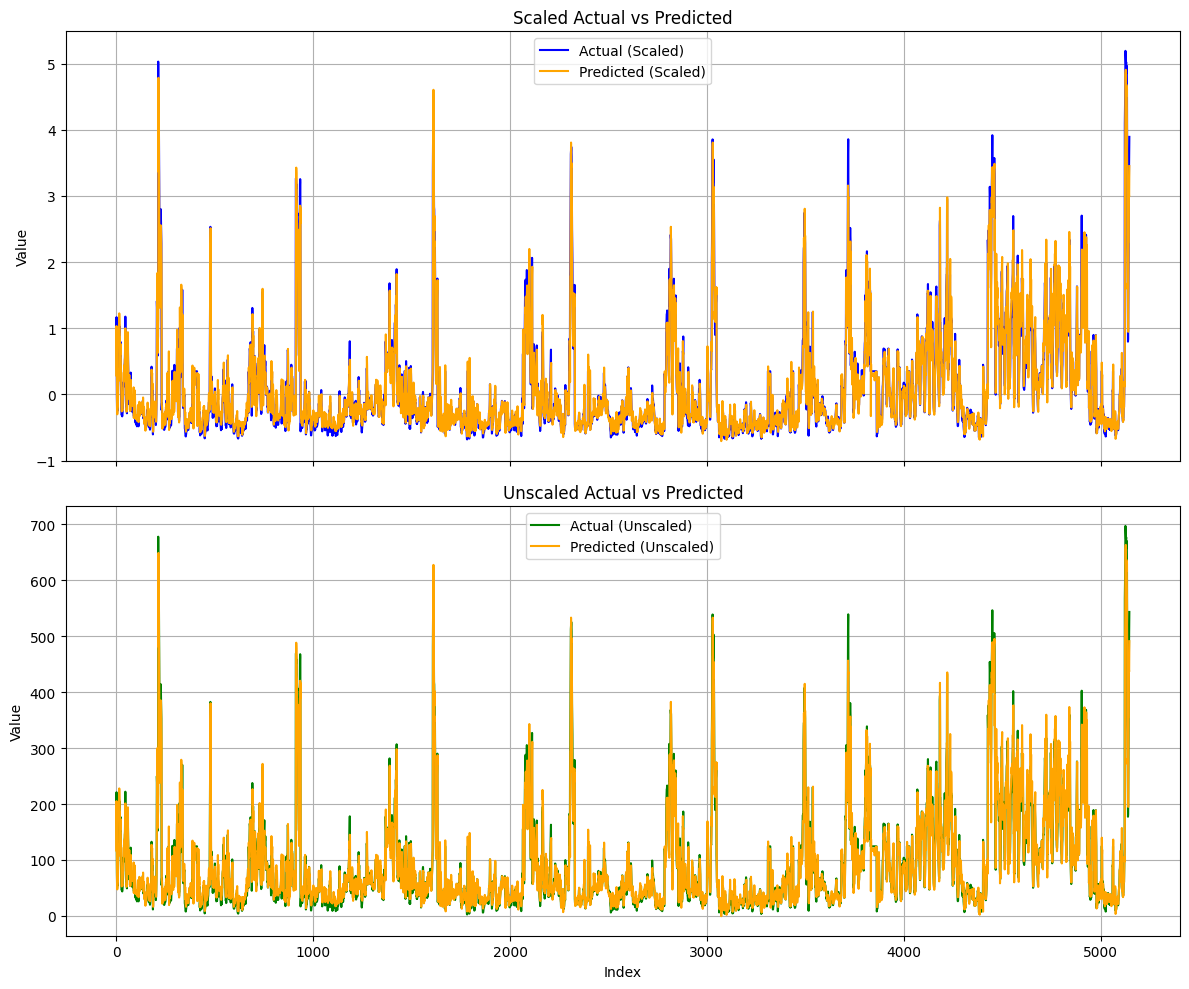

In [10]:
ui.results(df_test,model,scaler)

In [11]:
model=XGB_Model(X,Y)

Mean Squared Error: 0.346258927084741
Root Mean Squared Error: 0.5884377002578446


X shape == (5147, 48, 14).
Y shape == (5147, 1).
Mean Squared Error (MSE) of Scaled Values: 0.057042940479268944
Root Mean Squared Error (RMSE) of Scaled Values: 0.23883663973366595
Mean Squared Error (MSE) of Unscaled Values: 797.6350084683099
Root Mean Squared Error (RMSE) of Unscaled Values: 28.242432764694865


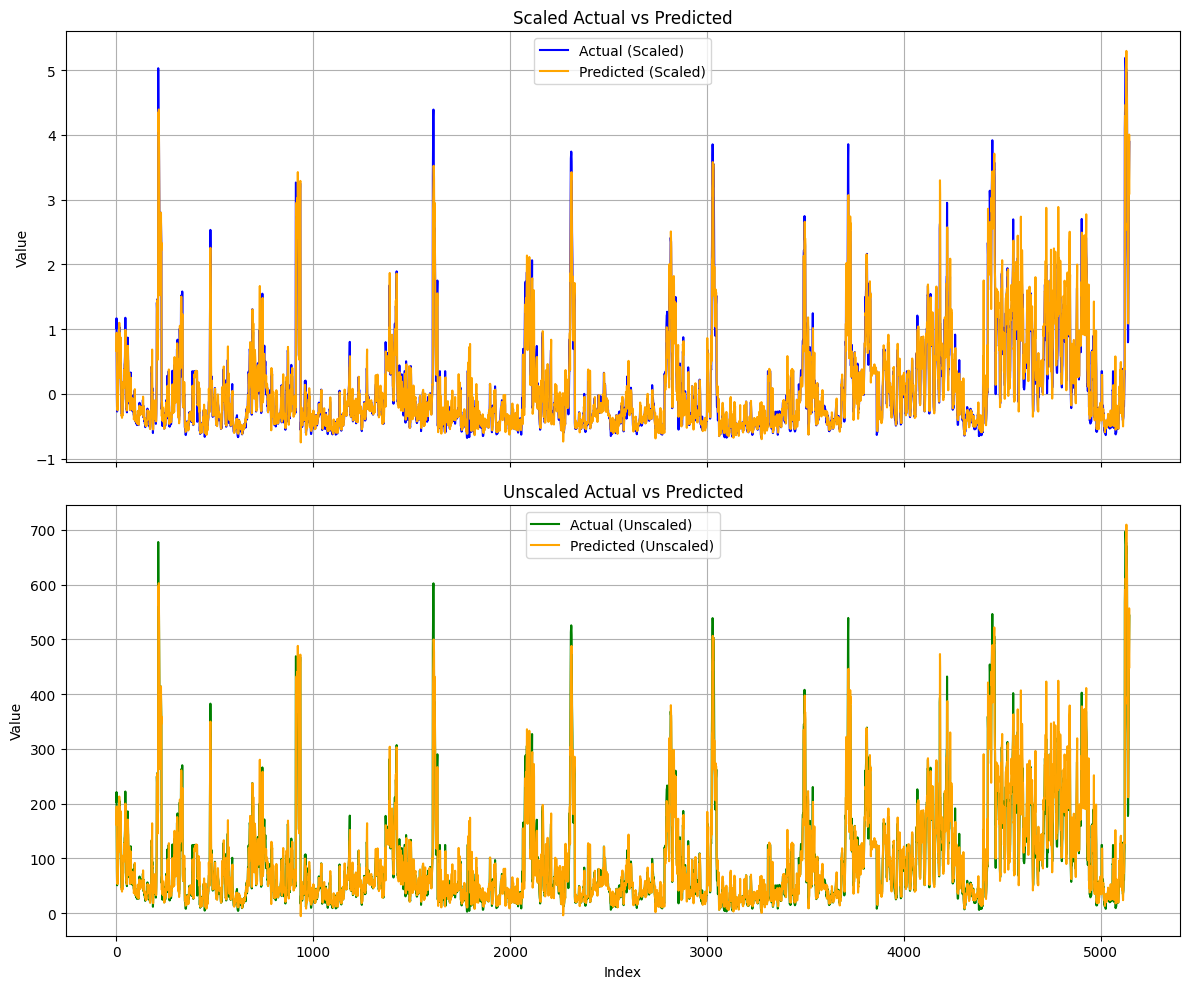

In [12]:
ui.results(df_test,model,scaler,model_name='XGB')